In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def writePopulationConfigurations(nDemes, sampleSize, Ne):
    """
    When several populations or demes have to be simulated, msprime requires the 'population_configurations' parameter.
    This arameter is a list of 'PopulationConfiguration' methods, one call to this method per population or deme.
        nDemes = number of demes or populations to simulate
        sampleSize = number of individuals to sample in each deme/population (to simulate 1 diploid individual,
            sampleSize must be 2)
    """
    population_configurations = []
    for i in range(0, nDemes):
        population_configurations.append(msprime.PopulationConfiguration(sample_size=2*sampleSize, initial_size = Ne))
    return(population_configurations)

def writeMigrationMatrix(n, rate):
    """
    Migrations in a 1-dimensional linear stepping-stone model with IBD.
        n = the number of demes 
        rate = migration rate between 2 demes
    """
    migration_matrix = np.zeros((n, n))
    for i in np.arange(1, n-1):
        migration_matrix[i, i+1] = migration_matrix[i, i-1] = migration_matrix[i+1, i] = migration_matrix[i-1, i] = rate
    migration_matrix[0, 1] = migration_matrix[1, 0] = migration_matrix[n-1, n-2] = migration_matrix[n-2, n-1] = rate
    
    return(migration_matrix)

In [3]:
Ne = 15000
M = 1
m = M / (4*Ne)

nbDemes = 10
nbSamples = 1

T = 20000

population_configurations = writePopulationConfigurations(nbDemes, nbSamples, Ne)
demographic_events = [
    msprime.MigrationRateChange(0, rate=m, matrix_index=(0,1)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(1,0)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(1,2)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(2,1)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(2,3)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(3,2)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(3,4)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(4,3)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(5,6)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(6,5)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(6,7)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(7,6)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(7,8)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(8,7)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(8,9)),
    msprime.MigrationRateChange(0, rate=m, matrix_index=(9,8)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(0,1)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(1,0)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(1,2)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(2,1)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(2,3)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(3,2)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(3,4)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(4,3)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(4,5)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(5,4)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(5,6)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(6,5)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(6,7)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(7,6)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(7,8)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(8,7)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(8,9)),
    msprime.MigrationRateChange(T, rate=m, matrix_index=(9,8))
  ]

In [4]:
def ibd_1d(num_replicates, population_configurations, demographic_events, nbDemes, nb_samples):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    - Entries:
        num_replicates = number of replicates
        population_configurations = the list of PopulationConfiguration instances describing the sampling configuration
        migration_matrix = the matrix describing the rates of migration between all pairs of populations
        nbDemes = number of demes or populations to simulate
        nb_samples = number of diploid samples taken in each deme or population
    - Returns:
        an array containing haplotypes for all the SNPs
    """
    s = 0
    replicates = msprime.simulate(
                            population_configurations = population_configurations,
                            demographic_events = demographic_events,
                            length = 20, 
                            recombination_rate = 1e-8,
                            mutation_rate = 1e-8,
                            num_replicates = num_replicates
                                 )
    for j, ts in enumerate(replicates): 
        # For each replicate, create a dimensions 3 array of size (number of SNPs, number of diploid samples, 2). This 
        # array will contain the haplotypes for the SNPs of the replicate.
        # Number of diploid samples = number of samples in the replicate / 2 since msprime simulates haploids.
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            # For each SNP, the genotypes (1-dimension arrays) are reshaped in 2-dimensions arrays of size (total number
            # of diploid samples, 2). The '2' refers to the diploidy.
            h[variant.index] = np.reshape(variant.genotypes , (nbDemes*nb_samples,2))
        # The haplotypes of all the SNPs generated in the replicates are concatenated into one array called haplotypes,
        # which is returned by the function.
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    
    return(haplotypes)

In [5]:
g = allel.model.GenotypeArray(ibd_1d(6000, population_configurations,
                                                         demographic_events, nbDemes, nbSamples))
# with open("2pops_ibd.txt", "w") as f:
#     for ind in np.arange(gn.shape[1]):
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])
# g

# with open("coords_2pops.txt", "w") as f:
#     for i in np.arange(nbDemes):
#         for n in np.arange(nbSamples):
#             f.write("%s\t%s\n" % (0, i))

In [6]:
gn = g.to_n_alt()[:]

gn

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 2, 0, 2],
       [1, 2, 1, ..., 2, 2, 2],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [7]:
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

(10, 10)

In [8]:
demes = []
palette = sns.color_palette("hls", nbDemes)
deme_colors = {}
sample_list = []
for i in np.arange(nbDemes):
    name = "deme" + str(i+1)
    demes.append(name)
    deme_colors[name] = palette[i]
    for j in np.arange(nbSamples):
        sample_list.append(name)

Text(0.5,1.01,'Pure IBD, 1D habitat.')

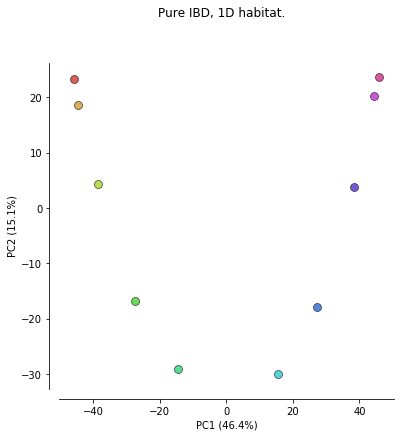

In [9]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    """
    Plots the PCA biplot pc2 = f(pc1) in the IBD 1D scenario. Samples are colored according to the deme they belong to, 
    in a rainbow palette.
        coords = transformed coordinates for the samples (given by allel.stats.pca)
        model = model instance containing the variance ratio explained and the stored components (a.k.a., loadings). Given by allel.stats.pca.
        pc1 = principal component on the x-axis (e.g. 0 for PC1)
        pc2 = principal component on the y-axis (e.g. 1 for PC2)
        ax = matplotlib axes for plotting
    """
    i = 0
    for t in demes:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=t, markersize=8, mec='k', mew=.5, color=deme_colors[t])
        i += nbSamples
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
fig.suptitle("Pure IBD, 1D habitat.", y=1.01)

Text(0.5,1.02,'PC maps')

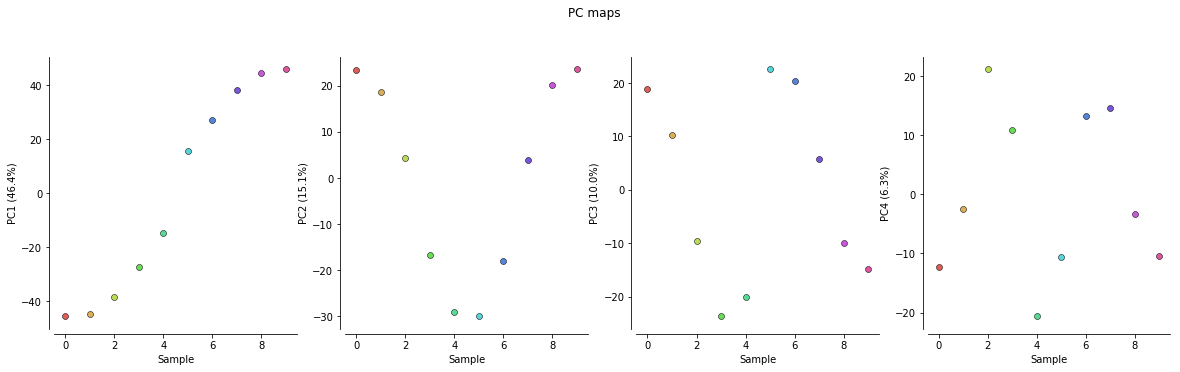

In [12]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    l = 0
    for d in demes:
        y = coords[i:i+nbSamples, pc]
        l += len(y)
        ax.plot(list(range(i, l)), y, marker='o', linestyle=' ', label=d, color=deme_colors[d], markersize=6, mec='k', mew=.5)
        i = l
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Sample')
    
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(1,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(1,4,4)
plot_PC_maps(coords, model, 3, ax)
fig.suptitle('PC maps', y=1.02)